# This will be feature selection based on the paper by kniep HC in which they get tid off all those tumors which volume is less than 125 and select the 10 lasrgest metastsis per patient. I am going to go with 15 for now. The rest would be applying the same codes as before. Only the radiomic features of the 3 classes: Melanomma, Lung, Breast (0, 1, 2).

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate, KFold, RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import VotingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_selection import VarianceThreshold
from collections import Counter
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import Pipeline as imbpipeline
from mrmr import mrmr_classif
from scipy import stats
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import f_classif

In [15]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, multi_class='ovr', average=average)

from sklearn.metrics import roc_auc_score

def class_vs_rest_roc_auc_score(y_test, y_pred):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test_bin = lb.transform(y_test)
    y_pred_bin = lb.transform(y_pred)
    roc_auc_scores = {}

    for i, class_label in enumerate(lb.classes_):
        class_indices = lb.transform([class_label])[0]
        rest_indices = ~class_indices
        y_test_class = y_test_bin[:, i]
        y_test_rest = y_test_bin[:, rest_indices]
        y_pred_class = y_pred_bin[:, i]
        y_pred_rest = y_pred_bin[:, rest_indices]
        roc_auc_scores[class_label] = roc_auc_score(y_test_class, y_pred_class, multi_class='ovr', average="macro")

    return roc_auc_scores

def calculate_specificity(cm):
    num_classes = cm.shape[0]
    specificity = {}

    for i in range(num_classes):
        tp = cm[i, i]
        tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
        fp = np.sum(cm[:, i]) - tp
        fn = np.sum(cm[i, :]) - tp

        specificity[i] = 100*(tn / (tn + fp))

    return specificity

def calculate_sensitivity(cm):
    num_classes = cm.shape[0]
    sensitivity = {}

    for i in range(num_classes):
        tp = cm[i, i]
        fn = np.sum(cm[i, :]) - tp

        sensitivity[i] = 100*(tp / (tp + fn))

    return sensitivity


def calculate_precision(cm):
    num_classes = cm.shape[0]
    precision = {}

    for i in range(num_classes):
        tp = cm[i, i]
        fp = np.sum(cm[:, i]) - tp

        precision[i] = 100*(tp / (tp + fp))

    return precision


def calculate_f1_score(cm):
    num_classes = cm.shape[0]
    f1_scores = {}

    for i in range(num_classes):
        tp = cm[i, i]
        fp = np.sum(cm[:, i]) - tp
        fn = np.sum(cm[i, :]) - tp

        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1_scores[i] = 2 * ((precision * recall) / (precision + recall)) * 100

    return f1_scores

def calculate_accuracy(cm):
    num_classes = cm.shape[0]
    accuracy = {}

    for i in range(num_classes):
        tp = cm[i, i]
        fp = np.sum(cm[:, i]) - tp
        fn = np.sum(cm[i, :]) - tp
        tn = np.sum(cm) - tp - fp - fn

        accuracy[i] = 100 * ((tp + tn) / (tp + tn + fp + fn))

    return accuracy

In [16]:
df = pd.read_excel('all_patients.xlsx')
#df = df.set_index(['subjid'])
df = df.drop('number_annotations', axis = 1)
df = df[df.shape_VoxelVolume > 125]
df.drop(df[df['labels'] == 3].index, inplace = True) ## dropping label of the call OTHERS
df = df.set_index(['subjid', 'label'])
confidence = 0.95
seed = 0
df

shape_Elongation  shape_Flatness  shape_LeastAxisLength   
subjid   label                                                            
Oslo01   1              0.829356        0.682981               8.512717  \
         2              0.944143        0.900681              14.133927   
Oslo02   4              0.849295        0.841082               8.703783   
         5              0.939828        0.821847              12.093804   
Oslo03   1              0.930698        0.629604              10.914986   
...                          ...             ...                    ...   
Stan_328 1              0.810571        0.325076               8.769420   
         8              0.967496        0.597282               6.131668   
         11             0.561746        0.506390               5.004740   
         12             0.959775        0.756903               5.164755   
Stan_338 4              0.819799        0.618051               8.548537   

                shape_MajorAxisLength  shape_Maximum2DDiameterColumn   
subjid   label                                                         
Oslo01   1                  12.464063                      14.866069  \
         2                  15.692487                      17.804494   
Oslo02   4                  10.348315                      10.816654   
         5                  14.715396                      17.262677   
Oslo03   1                  17.336268                      20.615528   
...                               ...                            ...   
Stan_328 1                  26.976501                      31.384710   
         8                  10.265944                      11.661904   
         11                  9.883181                       8.246211   
         12                  6.823538                       7.615773   
Stan_338 4                  13.831433                      14.142136   

                shape_Maximum2DDiameterRow  shape_Maximum2DDiameterSlice   
subjid   label                                                             
Oslo01   1                       14.560220                     12.529964  \
         2                       19.416488                     18.681542   
Oslo02   4                       11.704700                     11.704700   
         5                       17.888544                     17.492856   
Oslo03   1                       18.439089                     19.416488   
...                                    ...                           ...   
Stan_328 1                       28.160256                     27.459060   
         8                       12.369317                     12.165525   
         11                      11.704700                     10.000000   
         12                       8.602325                      8.602325   
Stan_338 4                       15.297059                     17.204651   

                shape_Maximum3DDiameter  shape_MeshVolume   
subjid   label                                              
Oslo01   1                    15.394804        728.083333  \
         2                    19.467922       2320.625000   
Oslo02   4                    12.449900        538.666667   
         5                    18.000000       1681.250000   
Oslo03   1                    20.712315       2068.958333   
...                                 ...               ...   
Stan_328 1                    33.075671       3310.541667   
         8                    12.688578        375.166667   
         11                   12.124356        159.791667   
         12                    8.602325        149.333333   
Stan_338 4                    17.291616        821.541667   

                shape_MinorAxisLength  ...  glszm_ZoneVariance   
subjid   label                         ...                       
Oslo01   1                  10.337151  ...        3.039725e+04  \
         2                  14.815951  ...        1.935116e+05   
Oslo02   4                   8.788767  ...        2.8454

In [17]:
# we select X and y
X = df.iloc[:, :-4] #leaving the sex and age features out for now
y = df.iloc[:, -1:]
print(Counter(y.values.ravel()))

Counter({1: 321, 2: 76, 0: 41})


There is an obvious inbalane of the labes wih a great majority coming from the lung. To counter attck this inbalance we eill make use of oversampling and undersapmling techniques that have proven to be useful in literature

## mRMR

In [68]:
pipelines = {
    'rf': imbpipeline([('smoteen', SMOTEENN(random_state=0)),
                       ('clf', RandomForestClassifier(random_state=0, class_weight="balanced"))]),
    #'svc': imbpipeline([('smoteen', SMOTEENN(random_state=0)),
                        #('clf', CalibratedClassifierCV(LinearSVC(multi_class='ovr', random_state=0, class_weight="balanced")))])
    }

param_grids = {
    'rf': {'clf__n_estimators': [100, 250, 1000, 3500]},
    #'svc': {'clf__base_estimator__C': [0.1, 1, 5, 10], 'clf__base_estimator__max_iter': [10000, 20000, 30000]}
}

cv_outer = RepeatedStratifiedKFold(n_splits=6, n_repeats=6, random_state=seed)

## f 10

In [19]:
# Store the scores and metrics
scores_rf = {'acc': [], 'SD_acc': [], 'CI_acc': [], 'auc_tot': [], 'SD_auc_tot': [], 'CI_auc_tot': [], 'auc_class': [], 'SD_auc_class': [], 'CI_auc_class': [], 'Sen_mean': [], 'Sen_CI': [], 'Sen_SD': [], 'Spe_mean': [], 'Spe_CI': [], 'Spe_sd': [], 'Pre_mean': [], 'Pre_CI': [], 'Pre_sd': [], 'F1_mean': [], 'F1_CI': [], 'F1_sd': [], 'Accy_mean': [], 'Accy_CI': [], 'Accy_sd': []}

best_features_RF = []

for name, pipeline in pipelines.items():
    # Initialize lists to store scores for each fold
    fold_acc = []
    fold_auc_tot = []
    fold_auc_class = []
    sensi = []
    speci = []
    prec = []
    f1 = []
    accy = []
    features = []
    p_value = []
    feat = []
    value = []
    for train_index, test_index in cv_outer.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        scaler = StandardScaler()
        X_train_normed = scaler.fit_transform(X_train)
        X_test_normed = scaler.transform(X_test)

        X_train_scal = pd.DataFrame(X_train_normed, columns=X_train.columns, index=X_train.index)
        X_test_scal = pd.DataFrame(X_test_normed, columns=X_test.columns, index=X_test.index)

        #select the best 15 features
        selected_feature_names = mrmr_classif(X_train_scal, y_train, K=10)
        X_train_new = X_train_scal[selected_feature_names]
        X_test_new = X_test_scal[selected_feature_names]
        f_scores, p_values = f_classif(X_train_new, y_train)
        feature_p_values = dict(zip(selected_feature_names, p_values))
        p_value.append(feature_p_values)

        cv_inner = RepeatedStratifiedKFold(n_splits=4, n_repeats=4, random_state=seed)
        grid_search = GridSearchCV(pipeline, param_grids[name], cv=cv_inner, scoring='roc_auc_ovr', error_score="raise")
        grid_search.fit(X_train_new, y_train)
        clf = grid_search.best_estimator_
        print(clf)
        clf.fit(X_train_new, y_train)
        y_pred = clf.predict(X_test_new)
        accuracy = accuracy_score(y_test, y_pred)
        num_classes = len(np.unique(y_test))
        cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
        specificity = calculate_specificity(cm)
        sensitivity = calculate_sensitivity(cm)
        precision = calculate_precision(cm)
        F1 = calculate_f1_score(cm)
        Accy = calculate_accuracy(cm)
        #sum_confusion_matrix_rf += cm
        # Print the results

        accuracy = accuracy_score(y_test, y_pred)
        fold_acc.append(accuracy)

        # Calculate AUC score
        auc_tot = multiclass_roc_auc_score(y_test, y_pred)
        fold_auc_tot.append(auc_tot)

        auc_class = class_vs_rest_roc_auc_score(y_test, y_pred)
        fold_auc_class.append(auc_class)

        speci.append(specificity)
        sensi.append(sensitivity)
        prec.append(precision)
        f1.append(F1)
        accy.append(Accy)

        print('Auc Score', multiclass_roc_auc_score(y_test, y_pred))
        print('Auc Score OvR', class_vs_rest_roc_auc_score(y_test, y_pred))

        if name == 'rf':
            params_rf = grid_search.best_estimator_
            feature_importance = clf.named_steps['clf'].feature_importances_
            for featureses, importance in zip(selected_feature_names, feature_importance):
                best_features_RF.append((featureses, importance))
        else:
            continue
    # Calculate average scores across folds
    if name == 'rf':
       #acc
        avg_acc = np.mean(fold_acc)
        scores_rf['acc'].append(avg_acc)
        scores_rf['acc'] = scores_rf['acc'][-1]
        ci = stats.t.interval(confidence, len(fold_acc) - 1, loc=np.mean(fold_acc), scale=stats.sem(fold_acc))
        scores_rf['CI_acc'].append(ci)
        scores_rf['SD_acc'].append(np.std(fold_acc))

        #auc_tot
        avg_auc_tot = np.mean(fold_auc_tot)
        scores_rf['auc_tot'].append(avg_auc_tot)
        scores_rf['auc_tot'] = scores_rf['auc_tot'][-1]
        ci = stats.t.interval(confidence, len(fold_auc_tot) - 1, loc=np.mean(fold_auc_tot), scale=stats.sem(fold_auc_tot))
        scores_rf['CI_auc_tot'].append(ci)
        scores_rf['SD_auc_tot'].append(np.std(fold_acc))

        #auc_class
        list_0 = list(d[0] for d in fold_auc_class)
        list_1 = list(d[1] for d in fold_auc_class)
        list_2 = list(d[2] for d in fold_auc_class)

        avg_auc_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_rf['auc_class'].append(avg_auc_class)

        sd_auc_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_rf['SD_auc_class'].append(sd_auc_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_auc_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_rf['CI_auc_class'].append(CI_auc_class)

        #sensitivity
        list_0 = list(d[0] for d in sensi)
        list_1 = list(d[1] for d in sensi)
        list_2 = list(d[2] for d in sensi)

        avg_sensi_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_rf['Sen_mean'].append(avg_sensi_class)

        sd_sensi_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_rf['Sen_SD'].append(sd_sensi_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_sen_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_rf['Sen_CI'].append(CI_sen_class)

        #specificity
        list_0 = list(d[0] for d in speci)
        list_1 = list(d[1] for d in speci)
        list_2 = list(d[2] for d in speci)

        avg_speci_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_rf['Spe_mean'].append(avg_speci_class)
        sd_speci_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_rf['Spe_sd'].append(sd_speci_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_spe_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_rf['Spe_CI'].append(CI_spe_class)

        #precision
        list_0 = list(d[0] for d in prec)
        list_1 = list(d[1] for d in prec)
        list_2 = list(d[2] for d in prec)

        avg_prec_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_rf['Pre_mean'].append(avg_prec_class)
        sd_prec_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_rf['Pre_sd'].append(sd_prec_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_pre_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_rf['Pre_CI'].append(CI_pre_class)

        #F1
        list_0 = list(d[0] for d in f1)
        list_1 = list(d[1] for d in f1)
        list_2 = list(d[2] for d in f1)

        avg_f1_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_rf['F1_mean'].append(avg_f1_class)
        sd_f1_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_rf['F1_sd'].append(sd_f1_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_F1_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_rf['F1_CI'].append(CI_F1_class)

        ###Accuracy per class
        list_0 = list(d[0] for d in accy)
        list_1 = list(d[1] for d in accy)
        list_2 = list(d[2] for d in accy)

        avg_accy_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_rf['Accy_mean'].append(avg_accy_class)
        sd_accy_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_rf['Accy_sd'].append(sd_accy_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_accy_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_rf['Accy_CI'].append(CI_accy_class)

100%|██████████| 10/10 [00:01<00:00,  8.34it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.7284374449674997
Auc Score OvR {0: 0.7694805194805195, 1: 0.6296296296296297, 2: 0.7862021857923498}


100%|██████████| 10/10 [00:01<00:00,  9.08it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6297645089707212
Auc Score OvR {0: 0.645021645021645, 1: 0.5584795321637427, 2: 0.6857923497267759}


100%|██████████| 10/10 [00:01<00:00,  9.24it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6546484437993872
Auc Score OvR {0: 0.8333333333333334, 1: 0.5665094339622642, 2: 0.5641025641025642}


100%|██████████| 10/10 [00:01<00:00,  9.91it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.5988314620390093
Auc Score OvR {0: 0.4913419913419913, 1: 0.5820754716981132, 2: 0.7230769230769232}


100%|██████████| 10/10 [00:01<00:00,  9.93it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.6650497301440698
Auc Score OvR {0: 0.6980519480519481, 1: 0.625943396226415, 2: 0.6711538461538462}


100%|██████████| 10/10 [00:00<00:00, 10.03it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.6879455250363865
Auc Score OvR {0: 0.7437810945273631, 1: 0.5969785575048733, 2: 0.7230769230769232}


100%|██████████| 10/10 [00:01<00:00,  9.79it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.6539958073967277
Auc Score OvR {0: 0.5703463203463204, 1: 0.621832358674464, 2: 0.7698087431693988}


100%|██████████| 10/10 [00:01<00:00,  7.01it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.6526323155960775
Auc Score OvR {0: 0.6374458874458875, 1: 0.5847953216374271, 2: 0.7356557377049181}


100%|██████████| 10/10 [00:01<00:00,  9.57it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=0))])
Auc Score 0.6398661087340333
Auc Score OvR {0: 0.7283549783549784, 1: 0.5886792452830188, 2: 0.6025641025641026}


100%|██████████| 10/10 [00:01<00:00,  8.30it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6494115423360706
Auc Score OvR {0: 0.6645021645021645, 1: 0.629245283018868, 2: 0.6544871794871795}


100%|██████████| 10/10 [00:01<00:00,  9.82it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.7194309882989129
Auc Score OvR {0: 0.7132034632034633, 1: 0.6636792452830188, 2: 0.7814102564102565}


100%|██████████| 10/10 [00:01<00:00,  9.78it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.60886762394356
Auc Score OvR {0: 0.6691542288557213, 1: 0.5414230019493177, 2: 0.6160256410256411}


100%|██████████| 10/10 [00:01<00:00,  9.04it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.6183809173814926
Auc Score OvR {0: 0.6190476190476191, 1: 0.5414230019493177, 2: 0.694672131147541}


100%|██████████| 10/10 [00:01<00:00,  9.96it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.579338656848004
Auc Score OvR {0: 0.5854978354978355, 1: 0.49951267056530213, 2: 0.6530054644808744}


100%|██████████| 10/10 [00:01<00:00,  9.77it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.5476403051874751
Auc Score OvR {0: 0.461038961038961, 1: 0.45047169811320753, 2: 0.7314102564102565}


100%|██████████| 10/10 [00:01<00:00,  9.96it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6051051673693183
Auc Score OvR {0: 0.7619047619047621, 1: 0.49764150943396224, 2: 0.5557692307692308}


100%|██████████| 10/10 [00:01<00:00,  9.58it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.731499370650314
Auc Score OvR {0: 0.7997835497835498, 1: 0.6165094339622641, 2: 0.7782051282051281}


100%|██████████| 10/10 [00:01<00:00,  8.97it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.6006755098402127
Auc Score OvR {0: 0.5559701492537313, 1: 0.5165692007797271, 2: 0.7294871794871794}


100%|██████████| 10/10 [00:01<00:00,  9.95it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.659586296701626
Auc Score OvR {0: 0.5930735930735931, 1: 0.6247563352826511, 2: 0.7609289617486339}


100%|██████████| 10/10 [00:01<00:00,  9.85it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.712009262268106
Auc Score OvR {0: 0.7543290043290043, 1: 0.6125730994152047, 2: 0.7691256830601094}


100%|██████████| 10/10 [00:01<00:00,  9.29it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.5814631908971531
Auc Score OvR {0: 0.6038961038961039, 1: 0.4693396226415094, 2: 0.6711538461538462}


100%|██████████| 10/10 [00:01<00:00,  7.61it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=0))])
Auc Score 0.648659411866959
Auc Score OvR {0: 0.6677489177489178, 1: 0.5820754716981132, 2: 0.6961538461538461}


100%|██████████| 10/10 [00:01<00:00,  9.56it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.7053932964310322
Auc Score OvR {0: 0.7359307359307359, 1: 0.5853773584905659, 2: 0.7948717948717949}


100%|██████████| 10/10 [00:01<00:00,  9.41it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.5943999077934663
Auc Score OvR {0: 0.7002487562189056, 1: 0.5073099415204678, 2: 0.5756410256410255}


100%|██████████| 10/10 [00:01<00:00,  7.26it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.6247947413104158
Auc Score OvR {0: 0.6525974025974026, 1: 0.5940545808966862, 2: 0.6277322404371586}


100%|██████████| 10/10 [00:01<00:00,  9.53it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.651644359007028
Auc Score OvR {0: 0.6038961038961039, 1: 0.5477582846003899, 2: 0.8032786885245902}


100%|██████████| 10/10 [00:01<00:00,  9.58it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.627306236740199
Auc Score OvR {0: 0.6645021645021645, 1: 0.5443396226415095, 2: 0.6730769230769231}


100%|██████████| 10/10 [00:01<00:00,  9.28it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.6146506009713557
Auc Score OvR {0: 0.6980519480519481, 1: 0.5382075471698112, 2: 0.6076923076923078}


100%|██████████| 10/10 [00:01<00:00,  8.10it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.6866397229604777
Auc Score OvR {0: 0.7435064935064934, 1: 0.5882075471698113, 2: 0.7282051282051282}


100%|██████████| 10/10 [00:01<00:00,  9.62it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.56161352854859
Auc Score OvR {0: 0.6007462686567164, 1: 0.4731968810916179, 2: 0.610897435897436}


100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=0))])
Auc Score 0.5713158953020904
Auc Score OvR {0: 0.4913419913419913, 1: 0.5614035087719298, 2: 0.6612021857923498}


100%|██████████| 10/10 [00:01<00:00,  5.56it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=0))])
Auc Score 0.6036834614272061
Auc Score OvR {0: 0.5400432900432901, 1: 0.5599415204678362, 2: 0.7110655737704918}


100%|██████████| 10/10 [00:01<00:00,  6.28it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.6128484722824346
Auc Score OvR {0: 0.6980519480519481, 1: 0.49433962264150944, 2: 0.6461538461538461}


100%|██████████| 10/10 [00:01<00:00,  6.37it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.6526254667764101
Auc Score OvR {0: 0.6266233766233766, 1: 0.5665094339622642, 2: 0.7647435897435898}


100%|██████████| 10/10 [00:01<00:00,  6.63it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.7340697038810245
Auc Score OvR {0: 0.8528138528138529, 1: 0.6731132075471699, 2: 0.6762820512820512}


100%|██████████| 10/10 [00:01<00:00,  6.73it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.549922340613621
Auc Score OvR {0: 0.5485074626865671, 1: 0.42690058479532167, 2: 0.6743589743589744}


In [20]:
for name, score in scores_rf.items():
    print('rf', f'{name}: {score}')

rf acc: 0.38698630136986295
rf SD_acc: [0.05387111969861605]
rf CI_acc: [(0.3685003797438053, 0.4054722229959206)]
rf auc_tot: 0.6378929812310685
rf SD_auc_tot: [0.05387111969861605]
rf CI_auc_tot: [(0.6204564615673896, 0.6553295008947474)]
rf auc_class: [{0: 0.6589769406933585, 1: 0.562800060073314, 2: 0.6919019429265331}]
rf SD_auc_class: [{0: 0.09383390906196587, 1: 0.05803313213728958, 2: 0.06783343633305608}]
rf CI_auc_class: [{0: (0.626777753104713, 0.6911761282820041), 1: (0.5428859402553785, 0.5827141798912494), 2: (0.6686248401914425, 0.7151790456616236)}]
rf Sen_mean: [{0: 63.35978835978837, 1: 27.41381318425343, 2: 73.14814814814815}]
rf Sen_CI: [{0: (57.3457841676382, 69.37379255193854), 1: (25.211037013301762, 29.6165893552051), 2: (68.1046301515038, 78.1916661447925)}]
rf Sen_SD: [{0: 17.52583107604537, 1: 6.419264409696807, 2: 14.697669242325764}]
rf Spe_mean: [{0: 68.43559977888334, 1: 85.14619883040935, 2: 65.2322404371585}]
rf Spe_CI: [{0: (66.12136029960635, 70.74983

In [30]:
fold_auc_class

[{0: 0.7694805194805195, 1: 0.6296296296296297, 2: 0.7862021857923498},
 {0: 0.645021645021645, 1: 0.5584795321637427, 2: 0.6857923497267759},
 {0: 0.8333333333333334, 1: 0.5665094339622642, 2: 0.5641025641025642},
 {0: 0.4913419913419913, 1: 0.5820754716981132, 2: 0.7230769230769232},
 {0: 0.6980519480519481, 1: 0.625943396226415, 2: 0.6711538461538462},
 {0: 0.7437810945273631, 1: 0.5969785575048733, 2: 0.7230769230769232},
 {0: 0.5703463203463204, 1: 0.621832358674464, 2: 0.7698087431693988},
 {0: 0.6374458874458875, 1: 0.5847953216374271, 2: 0.7356557377049181},
 {0: 0.7283549783549784, 1: 0.5886792452830188, 2: 0.6025641025641026},
 {0: 0.6645021645021645, 1: 0.629245283018868, 2: 0.6544871794871795},
 {0: 0.7132034632034633, 1: 0.6636792452830188, 2: 0.7814102564102565},
 {0: 0.6691542288557213, 1: 0.5414230019493177, 2: 0.6160256410256411},
 {0: 0.6190476190476191, 1: 0.5414230019493177, 2: 0.694672131147541},
 {0: 0.5854978354978355, 1: 0.49951267056530213, 2: 0.653005464480874

In [36]:
random_forest_radiomic_features_melanoma = list(d[0] for d in fold_auc_class)
random_forest_radiomic_features_lung = list(d[1] for d in fold_auc_class)
random_forest_radiomic_features_breast = list(d[2] for d in fold_auc_class)
data_list = [random_forest_radiomic_features_melanoma, random_forest_radiomic_features_lung, random_forest_radiomic_features_breast]

([<matplotlib.axis.XTick at 0x7f2111822850>,
 [Text(1, 0, 'Melanoma_RF_RaFe'),
  Text(2, 0, 'Lung_RF_RaFe'),
  Text(3, 0, 'Breast_RF_RaFe')])

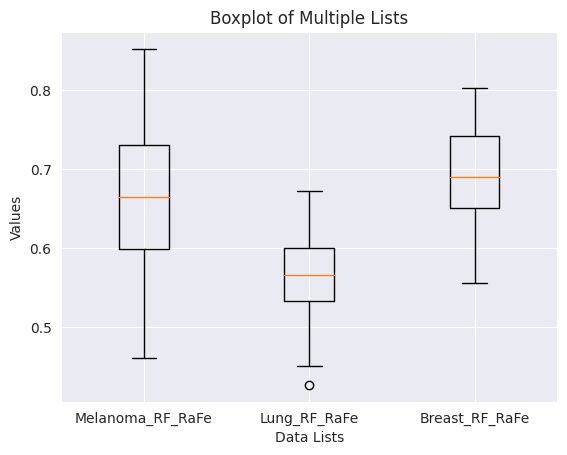

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
#sns.boxplot(random_forest_radiomic_features_melanoma)
plt.boxplot(data_list)
plt.title('Boxplot of Multiple Lists')
plt.xlabel('Data Lists')
plt.ylabel('Values')
plt.xticks(ticks=range(1, len(data_list) + 1), labels=['Melanoma_RF_RaFe', 'Lung_RF_RaFe', 'Breast_RF_RaFe'])  # Customize x-axis labels

## f 10 + Age and Sex

In [46]:
df = pd.read_excel('all_patients.xlsx')
#df = df.set_index(['subjid'])
df = df.drop('number_annotations', axis = 1)
df = df[df.shape_VoxelVolume > 125]
df.drop(df[df['labels'] == 3].index, inplace = True) ## dropping label of the call OTHERS
df = df.set_index(['subjid', 'label'])

# we select X and y
X = df.iloc[:, :-4] #leaving the sex and age features out for now
y = df.iloc[:, -1:]
X_age_sex = df.iloc[:, :-1]
confidence = 0.95
seed = 0

In [47]:
# Store the scores and metrics
scores_rf = {'acc': [], 'SD_acc': [], 'CI_acc': [], 'auc_tot': [], 'SD_auc_tot': [], 'CI_auc_tot': [], 'auc_class': [], 'SD_auc_class': [], 'CI_auc_class': [], 'Sen_mean': [], 'Sen_CI': [], 'Sen_SD': [], 'Spe_mean': [], 'Spe_CI': [], 'Spe_sd': [], 'Pre_mean': [], 'Pre_CI': [], 'Pre_sd': [], 'F1_mean': [], 'F1_CI': [], 'F1_sd': [], 'Accy_mean': [], 'Accy_CI': [], 'Accy_sd': []}

best_features_RF = []
num_classes = len(np.unique(y))
sum_confusion_matrix_rf = np.zeros((num_classes, num_classes))
for name, pipeline in pipelines.items():
    # Initialize lists to store scores for each fold
    fold_acc = []
    fold_auc_tot = []
    fold_auc_class_1 = []
    sensi = []
    speci = []
    prec = []
    f1 = []
    accy = []
    features = []
    p_value = []
    feat = []
    value = []
    for train_index, test_index in cv_outer.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        scaler = StandardScaler()
        X_train_normed = scaler.fit_transform(X_train)
        X_test_normed = scaler.transform(X_test)

        X_train_scal = pd.DataFrame(X_train_normed, columns=X_train.columns, index=X_train.index)
        X_test_scal = pd.DataFrame(X_test_normed, columns=X_test.columns, index=X_test.index)

        #select the best 15 features
        selected_feature_names = mrmr_classif(X_train_scal, y_train, K=10)
        additional_columns = ['Age', 'F', 'M']
        X_train_new = X_train_scal[selected_feature_names].join(X_age_sex[additional_columns])
        X_test_new = X_test_scal[selected_feature_names].join(X_age_sex[additional_columns])
        f_scores, p_values = f_classif(X_train_new, y_train)
        feature_p_values = dict(zip(selected_feature_names, p_values))
        p_value.append(feature_p_values)

        cv_inner = RepeatedStratifiedKFold(n_splits=4, n_repeats=4, random_state=seed)
        grid_search = GridSearchCV(pipeline, param_grids[name], cv=cv_inner, scoring='roc_auc_ovr', error_score="raise")
        grid_search.fit(X_train_new, y_train)
        clf = grid_search.best_estimator_
        print(clf)
        clf.fit(X_train_new, y_train)
        y_pred = clf.predict(X_test_new)
        accuracy = accuracy_score(y_test, y_pred)
        num_classes = len(np.unique(y_test))
        cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
        specificity = calculate_specificity(cm)
        sensitivity = calculate_sensitivity(cm)
        precision = calculate_precision(cm)
        F1 = calculate_f1_score(cm)
        Accy = calculate_accuracy(cm)
        sum_confusion_matrix_rf += cm
        # Print the results

        accuracy = accuracy_score(y_test, y_pred)
        fold_acc.append(accuracy)

        # Calculate AUC score
        auc_tot = multiclass_roc_auc_score(y_test, y_pred)
        fold_auc_tot.append(auc_tot)

        auc_class = class_vs_rest_roc_auc_score(y_test, y_pred)
        fold_auc_class_1.append(auc_class)

        speci.append(specificity)
        sensi.append(sensitivity)
        prec.append(precision)
        f1.append(F1)
        accy.append(Accy)

        print('Auc Score', multiclass_roc_auc_score(y_test, y_pred))
        print('Auc Score OvR', class_vs_rest_roc_auc_score(y_test, y_pred))

100%|██████████| 10/10 [00:01<00:00,  8.35it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.796791268893656
Auc Score OvR {0: 0.8376623376623377, 1: 0.7344054580896685, 2: 0.8183060109289618}


100%|██████████| 10/10 [00:01<00:00,  9.43it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.6768000651017619
Auc Score OvR {0: 0.6082251082251082, 1: 0.6291423001949318, 2: 0.7930327868852459}


100%|██████████| 10/10 [00:01<00:00,  9.33it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.7542347065931972
Auc Score OvR {0: 0.867965367965368, 1: 0.6985849056603773, 2: 0.6961538461538461}


100%|██████████| 10/10 [00:01<00:00,  8.53it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6237758049078804
Auc Score OvR {0: 0.48051948051948046, 1: 0.6363207547169811, 2: 0.7544871794871795}


100%|██████████| 10/10 [00:01<00:00,  8.28it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6875564686885441
Auc Score OvR {0: 0.6385281385281385, 1: 0.6863207547169812, 2: 0.7378205128205128}


100%|██████████| 10/10 [00:01<00:00,  9.14it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6713266215033693
Auc Score OvR {0: 0.6293532338308457, 1: 0.6198830409356726, 2: 0.7647435897435898}


100%|██████████| 10/10 [00:01<00:00,  8.37it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.7298709356877318
Auc Score OvR {0: 0.5595238095238095, 1: 0.7373294346978558, 2: 0.8927595628415299}


100%|██████████| 10/10 [00:01<00:00,  8.58it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=0))])
Auc Score 0.7523655069671751
Auc Score OvR {0: 0.773809523809524, 1: 0.689571150097466, 2: 0.7937158469945356}


100%|██████████| 10/10 [00:01<00:00,  7.17it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.695233382969232
Auc Score OvR {0: 0.683982683982684, 1: 0.6773584905660377, 2: 0.7243589743589745}


100%|██████████| 10/10 [00:01<00:00,  7.94it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.6731757236474217
Auc Score OvR {0: 0.6385281385281385, 1: 0.6547169811320755, 2: 0.7262820512820513}


100%|██████████| 10/10 [00:01<00:00,  7.59it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.7241942543829335
Auc Score OvR {0: 0.6309523809523809, 1: 0.72688679245283, 2: 0.8147435897435897}


100%|██████████| 10/10 [00:01<00:00,  8.81it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.7282239275954908
Auc Score OvR {0: 0.8271144278606966, 1: 0.644736842105263, 2: 0.7128205128205128}


100%|██████████| 10/10 [00:01<00:00,  8.26it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6981722154644214
Auc Score OvR {0: 0.672077922077922, 1: 0.6539961013645225, 2: 0.7684426229508197}


100%|██████████| 10/10 [00:01<00:00,  8.98it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.7199698582715551
Auc Score OvR {0: 0.7099567099567099, 1: 0.6569200779727096, 2: 0.7930327868852459}


100%|██████████| 10/10 [00:01<00:00,  8.53it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6211017494036363
Auc Score OvR {0: 0.4956709956709957, 1: 0.6080188679245283, 2: 0.7596153846153846}


100%|██████████| 10/10 [00:01<00:00,  7.06it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6907013845693092
Auc Score OvR {0: 0.773809523809524, 1: 0.6136792452830188, 2: 0.6846153846153846}


100%|██████████| 10/10 [00:01<00:00,  7.86it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.8130126163145032
Auc Score OvR {0: 0.8528138528138529, 1: 0.7330188679245283, 2: 0.8532051282051282}


100%|██████████| 10/10 [00:01<00:00,  7.95it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.7164824214509996
Auc Score OvR {0: 0.6455223880597016, 1: 0.672514619883041, 2: 0.8314102564102563}


100%|██████████| 10/10 [00:01<00:00,  6.72it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.7010127052189175
Auc Score OvR {0: 0.5670995670995671, 1: 0.7251461988304093, 2: 0.8107923497267759}


100%|██████████| 10/10 [00:01<00:00,  8.65it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.7372540751890767
Auc Score OvR {0: 0.7099567099567099, 1: 0.7080896686159843, 2: 0.7937158469945356}


100%|██████████| 10/10 [00:01<00:00,  8.48it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.7000767052653845
Auc Score OvR {0: 0.7207792207792209, 1: 0.6518867924528301, 2: 0.7275641025641025}


100%|██████████| 10/10 [00:01<00:00,  8.88it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.5962769410882619
Auc Score OvR {0: 0.4426406926406926, 1: 0.5731132075471699, 2: 0.7730769230769231}


100%|██████████| 10/10 [00:01<00:00,  8.60it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.7899262163413107
Auc Score OvR {0: 0.788961038961039, 1: 0.7141509433962264, 2: 0.8666666666666667}


100%|██████████| 10/10 [00:01<00:00,  8.21it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.7580950398703737
Auc Score OvR {0: 0.8196517412935324, 1: 0.7251461988304093, 2: 0.7294871794871794}


100%|██████████| 10/10 [00:01<00:00,  8.54it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6877837221524308
Auc Score OvR {0: 0.6569264069264069, 1: 0.6632553606237818, 2: 0.7431693989071038}


100%|██████████| 10/10 [00:01<00:00,  8.05it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.7152070785231556
Auc Score OvR {0: 0.7099567099567099, 1: 0.692495126705653, 2: 0.7431693989071038}


100%|██████████| 10/10 [00:01<00:00,  8.45it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.7009805707918915
Auc Score OvR {0: 0.7099567099567099, 1: 0.6231132075471698, 2: 0.7698717948717949}


100%|██████████| 10/10 [00:01<00:00,  8.36it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.5766063077383833
Auc Score OvR {0: 0.5595238095238095, 1: 0.5863207547169812, 2: 0.5839743589743589}


100%|██████████| 10/10 [00:01<00:00,  8.49it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.725273625745324
Auc Score OvR {0: 0.6461038961038962, 1: 0.6797169811320756, 2: 0.85}


100%|██████████| 10/10 [00:01<00:00,  8.12it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.7680499884741833
Auc Score OvR {0: 0.7437810945273631, 1: 0.6988304093567251, 2: 0.8615384615384616}


100%|██████████| 10/10 [00:01<00:00,  7.13it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.7357231946676871
Auc Score OvR {0: 0.788961038961039, 1: 0.6832358674463939, 2: 0.7349726775956283}


100%|██████████| 10/10 [00:01<00:00,  8.88it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.7046258806756361
Auc Score OvR {0: 0.6569264069264069, 1: 0.6803118908382066, 2: 0.7766393442622951}


100%|██████████| 10/10 [00:01<00:00,  6.36it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.6360967125118068
Auc Score OvR {0: 0.5595238095238095, 1: 0.5891509433962264, 2: 0.7596153846153846}


100%|██████████| 10/10 [00:01<00:00,  8.52it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=250, random_state=0))])
Auc Score 0.7217887982038924
Auc Score OvR {0: 0.6948051948051948, 1: 0.6641509433962264, 2: 0.8064102564102564}


100%|██████████| 10/10 [00:01<00:00,  8.63it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.7441015483468313
Auc Score OvR {0: 0.7251082251082251, 1: 0.7174528301886793, 2: 0.7897435897435898}


100%|██████████| 10/10 [00:01<00:00,  8.18it/s]


Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6186353992520529
Auc Score OvR {0: 0.5087064676616916, 1: 0.5657894736842105, 2: 0.7814102564102565}


In [52]:
#fold_auc_class_1
random_forest_radiomic_features_age_and_sex_melanoma = list(d[0] for d in fold_auc_class_1)
random_forest_radiomic_features_age_and_sex_lung = list(d[1] for d in fold_auc_class_1)
random_forest_radiomic_features_age_and_sex_breast = list(d[2] for d in fold_auc_class_1)

In [53]:
data_list = [random_forest_radiomic_features_melanoma, random_forest_radiomic_features_age_and_sex_melanoma,random_forest_radiomic_features_lung, random_forest_radiomic_features_age_and_sex_lung, random_forest_radiomic_features_breast, random_forest_radiomic_features_age_and_sex_breast]

([<matplotlib.axis.YTick at 0x7f2110709bb0>,
 [Text(0, 0.1, '0.10'),
  Text(0, 0.15, '0.15'),
  Text(0, 0.2, '0.20'),
  Text(0, 0.25, '0.25'),
  Text(0, 0.3, '0.30'),
  Text(0, 0.35, '0.35'),
  Text(0, 0.4, '0.40'),
  Text(0, 0.45, '0.45'),
  Text(0, 0.5, '0.50'),
  Text(0, 0.55, '0.55'),
  Text(0, 0.6, '0.60'),
  Text(0, 0.65, '0.65'),
  Text(0, 0.7, '0.70'),
  Text(0, 0.75, '0.75'),
  Text(0, 0.8, '0.80'),
  Text(0, 0.85, '0.85'),
  Text(0, 0.9, '0.90')])

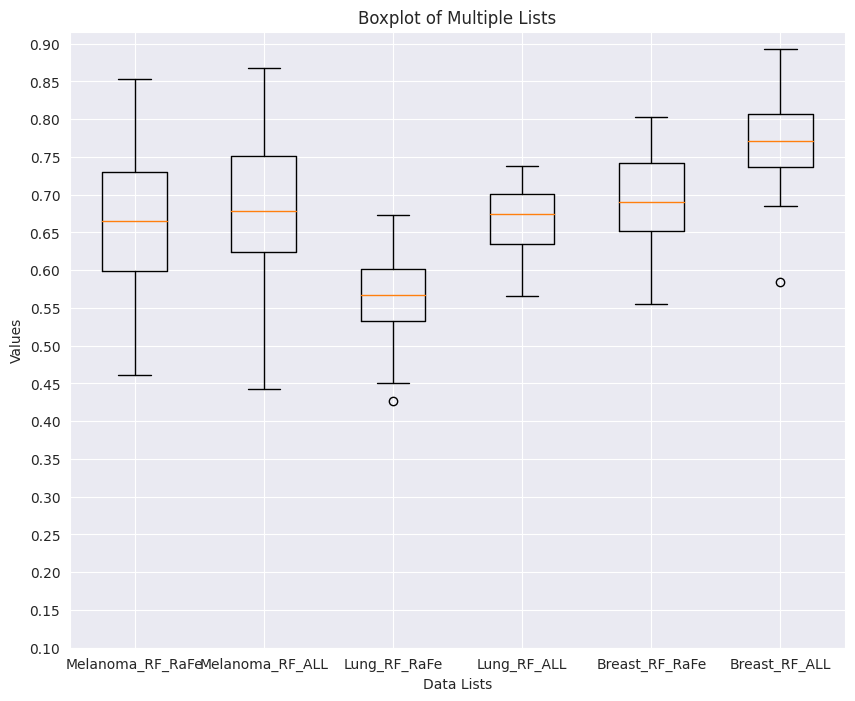

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
#sns.boxplot(random_forest_radiomic_features_melanoma)
plt.figure(figsize=(10, 8))
plt.boxplot(data_list)
plt.title('Boxplot of Multiple Lists')
plt.xlabel('Data Lists')
plt.ylabel('Values')
plt.xticks(ticks=range(1, len(data_list) + 1), labels=['Melanoma_RF_RaFe', 'Melanoma_RF_ALL','Lung_RF_RaFe', 'Lung_RF_ALL','Breast_RF_RaFe', 'Breast_RF_ALL'])  # Customize x-axis labels
desired_y_ticks = [0.1, 0.15, 0.2,0.25, 0.3, 0.35,0.4, 0.45,0.5, 0.55,0.6, 0.65, 0.7, 0.75, 0.8, 0.85 ,0.9]  # Adjust as needed
plt.yticks(desired_y_ticks)

## AGE & SEX RF

In [66]:
X_sex_age = X_age_sex[['Age', 'F', 'M']]
X_sex_age

Age  F  M
subjid   label           
Oslo01   1       58  0  1
         2       58  0  1
Oslo02   4       50  1  0
         5       50  1  0
Oslo03   1       64  0  1
...             ... .. ..
Stan_328 1       53  0  1
         8       53  0  1
         11      53  0  1
         12      53  0  1
Stan_338 4       42  1  0

[438 rows x 3 columns]

In [70]:
# Store the scores and metrics
scores_rf = {'acc': [], 'SD_acc': [], 'CI_acc': [], 'auc_tot': [], 'SD_auc_tot': [], 'CI_auc_tot': [], 'auc_class': [], 'SD_auc_class': [], 'CI_auc_class': [], 'Sen_mean': [], 'Sen_CI': [], 'Sen_SD': [], 'Spe_mean': [], 'Spe_CI': [], 'Spe_sd': []}


for name, pipeline in pipelines.items():
    # Initialize lists to store scores for each fold
    fold_acc = []
    fold_auc_tot = []
    fold_auc_class_2 = []
    sensi = []
    speci = []
    features = []
    p_value = []
    feat = []
    value = []
    for train_index, test_index in cv_outer.split(X_sex_age, y):
        X_train_new, X_test_new = X_sex_age.iloc[train_index], X_sex_age.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        cv_inner = RepeatedStratifiedKFold(n_splits=4, n_repeats=4, random_state=seed)
        grid_search = GridSearchCV(pipeline, param_grids[name], cv=cv_inner, scoring='roc_auc_ovr', error_score="raise")
        grid_search.fit(X_train_new, y_train)
        clf = grid_search.best_estimator_
        print(clf)
        clf.fit(X_train_new, y_train)
        y_pred = clf.predict(X_test_new)
        accuracy = accuracy_score(y_test, y_pred)
        num_classes = len(np.unique(y_test))
        cm = confusion_matrix(y_test, y_pred)
        specificity = calculate_specificity(cm)
        sensitivity = calculate_sensitivity(cm)
        # Print the results
        accuracy = accuracy_score(y_test, y_pred)
        fold_acc.append(accuracy)

        # Calculate AUC score
        auc_tot = multiclass_roc_auc_score(y_test, y_pred)
        fold_auc_tot.append(auc_tot)

        auc_class = class_vs_rest_roc_auc_score(y_test, y_pred)
        fold_auc_class_2.append(auc_class)

        speci.append(specificity)
        sensi.append(sensitivity)

        print('Auc Score', multiclass_roc_auc_score(y_test, y_pred))
        print('Auc Score OvR', class_vs_rest_roc_auc_score(y_test, y_pred))
    # Calculate average scores across folds
    if name == 'rf':
        #acc
        avg_acc = np.mean(fold_acc)
        scores_rf['acc'].append(avg_acc)
        scores_rf['acc'] = scores_rf['acc'][-1]
        ci = stats.t.interval(confidence, len(fold_acc) - 1, loc=np.mean(fold_acc), scale=stats.sem(fold_acc))
        scores_rf['CI_acc'].append(ci)
        scores_rf['SD_acc'].append(np.std(fold_acc))

        #auc_tot
        avg_auc_tot = np.mean(fold_auc_class_2)
        scores_rf['auc_tot'].append(avg_auc_tot)
        scores_rf['auc_tot'] = scores_rf['auc_tot'][-1]
        ci = stats.t.interval(confidence, len(fold_auc_tot) - 1, loc=np.mean(fold_auc_tot), scale=stats.sem(fold_auc_tot))
        scores_rf['CI_auc_tot'].append(ci)
        scores_rf['SD_auc_tot'].append(np.std(fold_auc_class_2))

        #auc_class
        list_0 = list(d[0] for d in fold_auc_class_2)
        list_1 = list(d[1] for d in fold_auc_class_2)
        list_2 = list(d[2] for d in fold_auc_class_2)

        avg_auc_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_rf['auc_class'].append(avg_auc_class)

        sd_auc_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_rf['SD_auc_class'].append(sd_auc_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_auc_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_rf['CI_auc_class'].append(CI_auc_class)

        #sensitivity
        list_0 = list(d[0] for d in sensi)
        list_1 = list(d[1] for d in sensi)
        list_2 = list(d[2] for d in sensi)

        avg_sensi_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_rf['Sen_mean'].append(avg_sensi_class)

        sd_sensi_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_rf['Sen_SD'].append(sd_sensi_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_sen_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_rf['Sen_CI'].append(CI_sen_class)

        #specificity
        list_0 = list(d[0] for d in speci)
        list_1 = list(d[1] for d in speci)
        list_2 = list(d[2] for d in speci)

        avg_speci_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_rf['Spe_mean'].append(avg_speci_class)
        sd_speci_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_rf['Spe_sd'].append(sd_speci_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_spe_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_rf['Spe_CI'].append(CI_spe_class)

Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.7149577246643685
Auc Score OvR {0: 0.7478354978354979, 1: 0.6798245614035089, 2: 0.7172131147540984}
Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6679537268406984
Auc Score OvR {0: 0.5562770562770563, 1: 0.6798245614035089, 2: 0.76775956284153}
Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=3500, random_state=0))])
Auc Score 0.6051818726347028
Auc Score OvR {0: 0.7326839826839826, 1: 0.6245283018867924, 2: 0.458333333333333

TypeError: unsupported operand type(s) for +: 'dict' and 'dict'

In [73]:
random_forest_age_and_sex_melanoma = list(d[0] for d in fold_auc_class_2)
random_forest_age_and_sex_lung = list(d[1] for d in fold_auc_class_2)
random_forest_age_and_sex_breast = list(d[2] for d in fold_auc_class_2)

In [84]:
data_list = [random_forest_age_and_sex_melanoma, random_forest_radiomic_features_melanoma, random_forest_radiomic_features_age_and_sex_melanoma,random_forest_age_and_sex_lung, random_forest_radiomic_features_lung, random_forest_radiomic_features_age_and_sex_lung, random_forest_age_and_sex_breast,random_forest_radiomic_features_breast, random_forest_radiomic_features_age_and_sex_breast]

([<matplotlib.axis.YTick at 0x7f21073f9880>,
 [Text(0, 0.1, '0.10'),
  Text(0, 0.15, '0.15'),
  Text(0, 0.2, '0.20'),
  Text(0, 0.25, '0.25'),
  Text(0, 0.3, '0.30'),
  Text(0, 0.35, '0.35'),
  Text(0, 0.4, '0.40'),
  Text(0, 0.45, '0.45'),
  Text(0, 0.5, '0.50'),
  Text(0, 0.55, '0.55'),
  Text(0, 0.6, '0.60'),
  Text(0, 0.65, '0.65'),
  Text(0, 0.7, '0.70'),
  Text(0, 0.75, '0.75'),
  Text(0, 0.8, '0.80'),
  Text(0, 0.85, '0.85'),
  Text(0, 0.9, '0.90')])

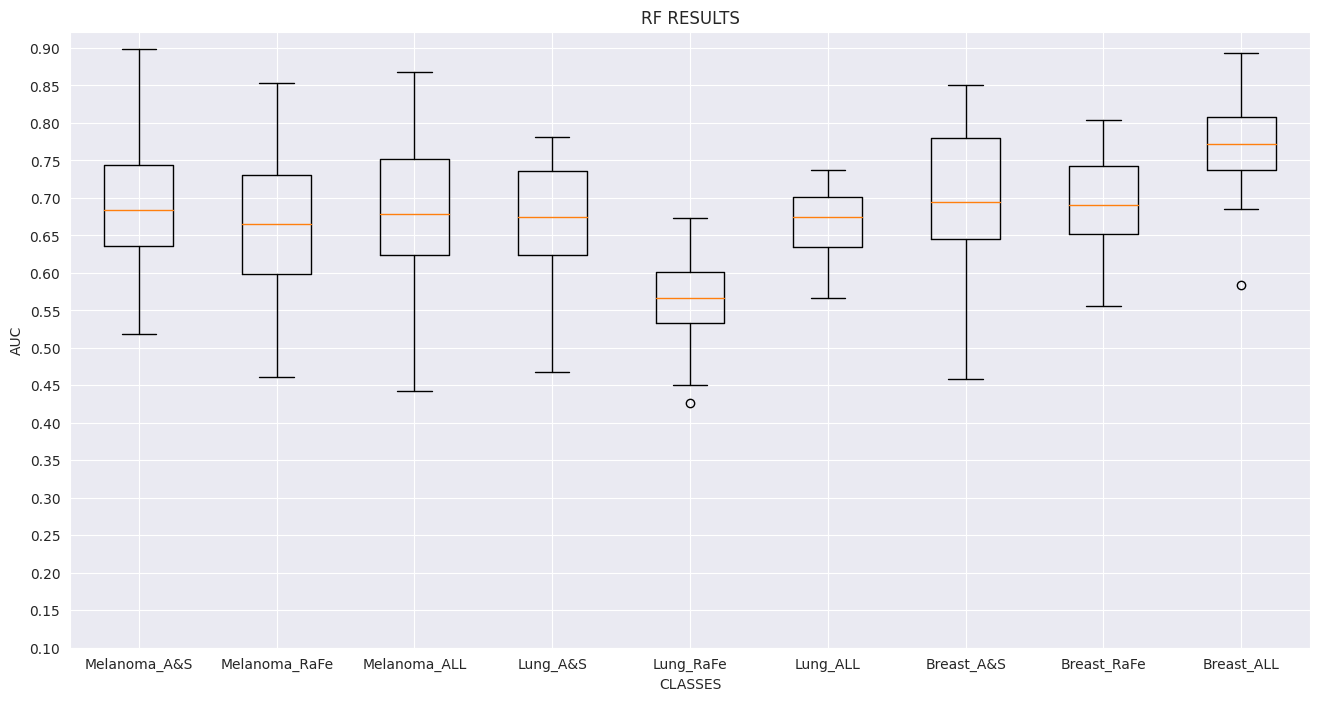

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt
#sns.boxplot(random_forest_radiomic_features_melanoma)
plt.figure(figsize=(16, 8))
plt.boxplot(data_list)
plt.title('RF RESULTS')
plt.xlabel('CLASSES')
plt.ylabel('AUC')
plt.xticks(ticks=range(1, len(data_list) + 1), labels=['Melanoma_A&S', 'Melanoma_RaFe', 'Melanoma_ALL', 'Lung_A&S', 'Lung_RaFe', 'Lung_ALL', 'Breast_A&S','Breast_RaFe', 'Breast_ALL'])  # Customize x-axis labels
desired_y_ticks = [0.1, 0.15, 0.2,0.25, 0.3, 0.35,0.4, 0.45,0.5, 0.55,0.6, 0.65, 0.7, 0.75, 0.8, 0.85 ,0.9]  # Adjust as needed
plt.yticks(desired_y_ticks)

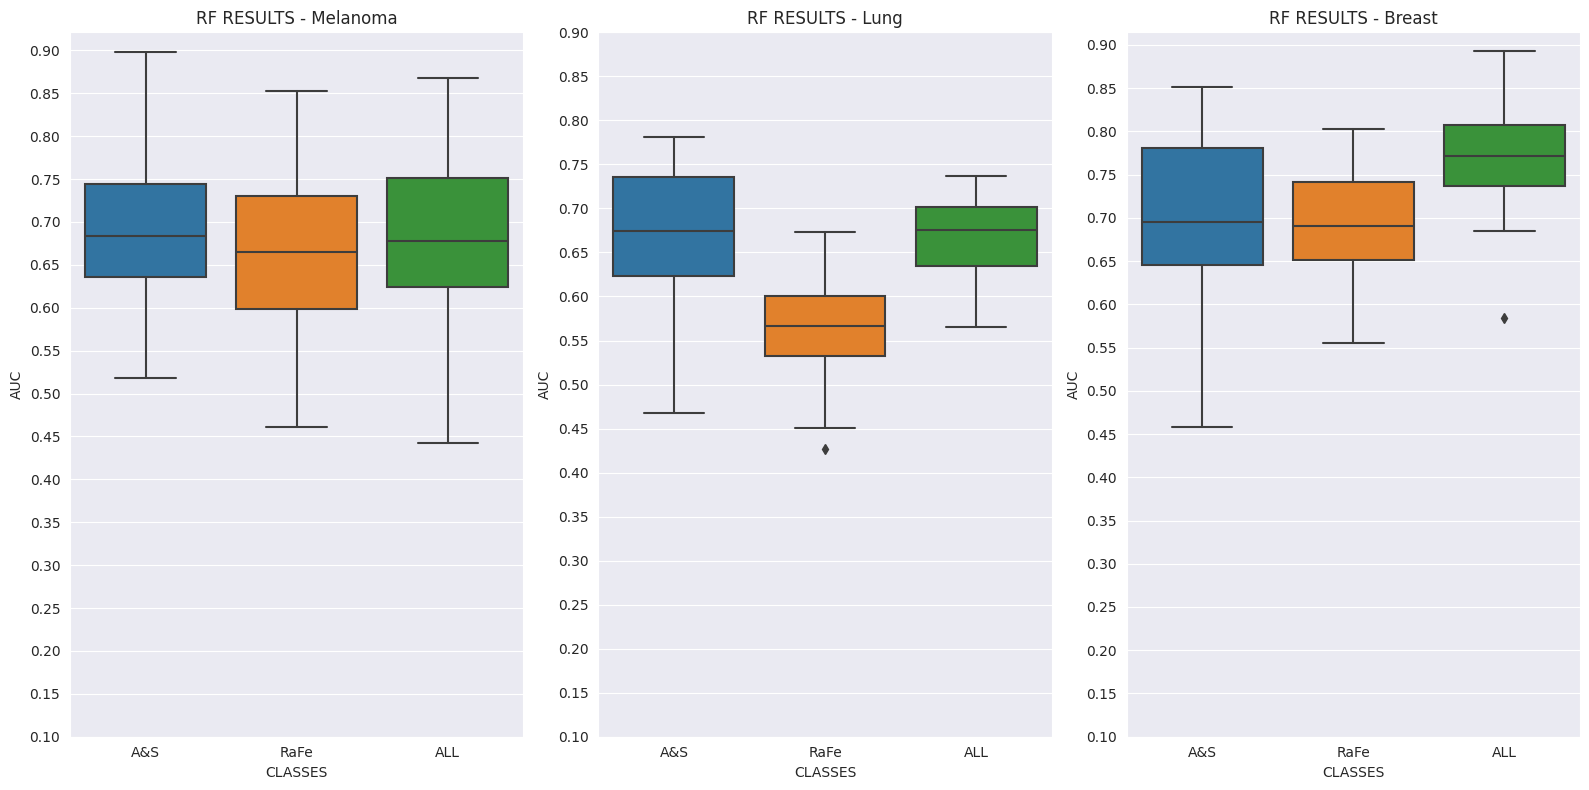

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt
# Create a figure with two subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 8))

# Plot the first three boxplots in the first subplot
sns.boxplot(data=data_list[:3], ax=ax1)
ax1.set_title('RF RESULTS - Melanoma')
ax1.set_xlabel('CLASSES')
ax1.set_ylabel('AUC')
ax1.set_xticklabels(['A&S', 'RaFe', 'ALL'])

# Plot the next three boxplots in the second subplot
sns.boxplot(data=data_list[3:6], ax=ax2)
ax2.set_title('RF RESULTS - Lung')
ax2.set_xlabel('CLASSES')
ax2.set_ylabel('AUC')
ax2.set_xticklabels(['A&S', 'RaFe', 'ALL'])

sns.boxplot(data=data_list[6:], ax=ax3)
ax3.set_title('RF RESULTS - Breast')
ax3.set_xlabel('CLASSES')
ax3.set_ylabel('AUC')
ax3.set_xticklabels(['A&S', 'RaFe', 'ALL'])

# Adjust y-axis ticks if needed
desired_y_ticks = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
ax1.set_yticks(desired_y_ticks)
ax2.set_yticks(desired_y_ticks)
ax3.set_yticks(desired_y_ticks)

# Adjust layout spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [92]:
data_list

[[0.7478354978354979,
  0.5562770562770563,
  0.7326839826839826,
  0.5183982683982683,
  0.683982683982684,
  0.7425373134328358,
  0.5411255411255411,
  0.762987012987013,
  0.683982683982684,
  0.5411255411255411,
  0.6915584415584416,
  0.781094527363184,
  0.6352813852813852,
  0.683982683982684,
  0.7067099567099567,
  0.7402597402597403,
  0.8982683982683983,
  0.6368159203980099,
  0.6688311688311688,
  0.5638528138528138,
  0.6915584415584416,
  0.7781385281385281,
  0.6125541125541125,
  0.8034825870646766,
  0.6612554112554112,
  0.604978354978355,
  0.683982683982684,
  0.7099567099567099,
  0.762987012987013,
  0.75,
  0.6688311688311688,
  0.683982683982684,
  0.6277056277056277,
  0.8603896103896104,
  0.6764069264069265,
  0.7276119402985074],
 [0.7694805194805195,
  0.645021645021645,
  0.8333333333333334,
  0.4913419913419913,
  0.6980519480519481,
  0.7437810945273631,
  0.5703463203463204,
  0.6374458874458875,
  0.7283549783549784,
  0.6645021645021645,
  0.7132034